In [1]:
import os
import cv2
import gc
import json
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer


<ipython-input-1-aaa55f4caea2>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForPreTraining

In [3]:
# Step 1: Mount Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:

# First, add the new paths to CFG class
class CFG:
    debug = False
    # Original dataset path
    image_path1 = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/Flicker8k_Dataset'
    captions_path1 = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset'

    # BNATURE dataset path
    image_path2 = '/content/drive/MyDrive/Bangla Image dataset with caption/BNATURE/Pictures'
    captions_path2 = '/content/drive/MyDrive/Bangla Image dataset with caption/BNATURE/caption/captions.json'

    # Bangla Lekha dataset path
    image_path3 = '/content/drive/MyDrive/Bangla Image dataset with caption/Bangla Lekha 2.0/images'
    captions_path3 = '/content/drive/MyDrive/Bangla Image dataset with caption/Bangla Lekha 2.0/captions.json'

    # Rest of the configuration remains the same
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "csebuetnlp/banglabert"
    text_embedding = 768
    text_tokenizer = "csebuetnlp/banglabert"
    max_length = 200

    pretrained = True
    trainable = True
    temperature = 1.0
    size = 224
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

In [41]:
def load_captions():
    """Load captions with validation"""
    captions_list = []

    # Load Flickr8k dataset
    try:
        with open(os.path.join(CFG.captions_path1, 'BAN-Cap_captiondata.json'), 'r', encoding='utf-8') as f:
            captions_data1 = json.load(f)

        for entry in captions_data1:
            if 'caption_id' in entry and 'bengali_caption' in entry:
                filename = entry['caption_id'].split('#')[0]
                caption = entry['bengali_caption']
                if caption and filename:  # Validate non-empty
                    captions_list.append({
                        "image": filename.strip(),
                        "caption": caption.strip()
                    })
    except Exception as e:
        print(f"Error loading Flickr8k dataset: {str(e)}")

    # Load BNATURE dataset
    try:
        with open(CFG.captions_path2, 'r', encoding='utf-8') as f:
            captions_data2 = json.load(f)

        for entry in captions_data2:
            if 'caption_id' in entry and 'bengali_caption' in entry:
                if entry['caption_id'] and entry['bengali_caption']:  # Validate non-empty
                    captions_list.append({
                        "image": entry['caption_id'].strip(),
                        "caption": entry['bengali_caption'].strip()
                    })
    except Exception as e:
        print(f"Error loading BNATURE dataset: {str(e)}")

    # Load Bangla Lekha dataset
    try:
        with open(CFG.captions_path3, 'r', encoding='utf-8') as f:
            captions_data3 = json.load(f)

        for entry in captions_data3:
            if 'filename' in entry and 'caption' in entry:
                if entry['filename'] and entry['caption']:  # Validate non-empty
                    captions_list.append({
                        "image": entry['filename'].strip(),
                        "caption": entry['caption'].strip()
                    })
    except Exception as e:
        print(f"Error loading Bangla Lekha dataset: {str(e)}")

    df = pd.DataFrame(captions_list)

    # Remove duplicates and null values
    df = df.dropna()
    df = df.drop_duplicates()

    # Add index
    df['id'] = df.index // 5

    print(f"Loaded {len(df)} valid caption entries")

    return df

In [42]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        Initialize CLIPDataset with validation
        """
        self.image_filenames = image_filenames
        self.captions = list(captions)

        # Encode all captions at once with fixed padding
        self.encoded_captions = tokenizer(
            list(captions),
            padding='max_length',  # Changed to max_length
            truncation=True,
            max_length=CFG.max_length,
            return_tensors='pt'  # Return PyTorch tensors
        )
        self.transforms = transforms

        # Validate data
        self.valid_indices = []
        for idx in range(len(self.image_filenames)):
            try:
                # Check if image exists in any of the paths
                image_found = False
                for path in [CFG.image_path1, CFG.image_path2, CFG.image_path3]:
                    if os.path.exists(os.path.join(path, self.image_filenames[idx])):
                        image_found = True
                        break

                if image_found:
                    self.valid_indices.append(idx)
            except Exception as e:
                print(f"Error processing index {idx}: {str(e)}")
                continue

        print(f"Found {len(self.valid_indices)} valid images out of {len(image_filenames)}")

    def __getitem__(self, idx):
        """
        Get a single item with error handling
        """
        try:
            actual_idx = self.valid_indices[idx]

            # Create item dictionary with encoded caption
            item = {
                'input_ids': self.encoded_captions['input_ids'][actual_idx],
                'attention_mask': self.encoded_captions['attention_mask'][actual_idx],
            }

            # Find correct image path
            image_path = None
            for path in [CFG.image_path1, CFG.image_path2, CFG.image_path3]:
                if os.path.exists(os.path.join(path, self.image_filenames[actual_idx])):
                    image_path = path
                    break

            if image_path is None:
                raise FileNotFoundError(f"Image {self.image_filenames[actual_idx]} not found in any path")

            # Load and process image
            image = cv2.imread(os.path.join(image_path, self.image_filenames[actual_idx]))
            if image is None:
                raise ValueError(f"Failed to load image: {self.image_filenames[actual_idx]}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
            item['caption'] = self.captions[actual_idx]

            return item

        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            # Return None or raise the exception based on your needs
            raise e

    def __len__(self):
        return len(self.valid_indices)

def build_loaders(dataframe, tokenizer, mode):
    """
    Build data loaders with error handling
    """
    transforms = get_transforms(mode=mode)

    try:
        dataset = CLIPDataset(
            image_filenames=dataframe["image"].values,
            captions=dataframe["caption"].values,
            tokenizer=tokenizer,
            transforms=transforms
        )

        # Custom collate function to handle potential None values
        def collate_fn(batch):
            # Filter out None values
            batch = [item for item in batch if item is not None]
            if len(batch) == 0:
                raise RuntimeError("Empty batch after filtering")

            return {
                'image': torch.stack([item['image'] for item in batch]),
                'input_ids': torch.stack([item['input_ids'] for item in batch]),
                'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
                'caption': [item['caption'] for item in batch]
            }

        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=CFG.batch_size,
            num_workers=CFG.num_workers,
            shuffle=True if mode == "train" else False,
            collate_fn=collate_fn,
            drop_last=True  # Drop incomplete batches
        )

        return dataloader

    except Exception as e:
        print(f"Error building dataloader: {str(e)}")
        raise e

In [43]:

class ImageEncoder(nn.Module):
    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

from transformers import AutoTokenizer, AutoModel, AutoConfig

class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = AutoModel.from_pretrained(model_name)
        else:
            self.model = AutoModel(config=AutoConfig.from_pretrained(model_name))

        for p in self.model.parameters():
            p.requires_grad = trainable
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x


In [44]:

class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0
        return loss.mean()


In [45]:

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [46]:

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )


In [47]:

def make_train_valid_dfs():
    dataframe = load_captions()
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [48]:

def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader



In [49]:
class AvgMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import torch
import itertools
from tqdm import tqdm
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np


# Compute cosine similarity
def compute_cosine_similarity(embeddings_a, embeddings_b):
    a = torch.nn.functional.normalize(embeddings_a, p=2, dim=-1)  # L2 normalize
    b = torch.nn.functional.normalize(embeddings_b, p=2, dim=-1)
    return torch.mm(a, b.t())  # Matrix multiplication for cosine similarity


# Precision and Recall computation
def precision_recall(similarity_matrix, k=5):
    """
    Calculate Precision@k and Recall@k for text-to-image matching.
    Args:
        similarity_matrix: torch.Tensor of shape [num_samples, num_samples]
        k: Number of top matches to consider
    Returns:
        precision: Average precision over all samples
        recall: Average recall over all samples
    """
    num_samples = similarity_matrix.size(0)
    relevant_items = torch.eye(num_samples, device=similarity_matrix.device)  # Identity matrix for ground truth
    top_k_indices = similarity_matrix.topk(k, dim=-1).indices  # Top-k indices for each row

    precision = 0
    recall = 0
    for i in range(num_samples):
        matches = relevant_items[i][top_k_indices[i]].sum().item()  # Count matches in top-k
        precision += matches / k  # Precision: Relevant matches in top-k
        recall += matches / relevant_items[i].sum().item()  # Recall: Matches out of all relevant items

    precision /= num_samples
    recall /= num_samples
    return precision, recall


# Training function
def train(model, train_loader, optimizer, lr_scheduler, step):
    model.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader), colour="green")

    for batch in tqdm_object:
        batch = {k: v.to(CFG.device, non_blocking=True) for k, v in batch.items() if k != "caption"}
        optimizer.zero_grad()

        loss = model(batch)
        loss.backward()
        optimizer.step()

        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    torch.cuda.empty_cache()
    return loss_meter


# Validation function with cosine similarity and metrics
def validate(model, valid_loader):
    model.eval()
    loss_meter = AvgMeter()
    all_image_embeddings = []
    all_text_embeddings = []

    with torch.no_grad():
        tqdm_object = tqdm(valid_loader, total=len(valid_loader), colour="blue")
        for batch in tqdm_object:
            batch = {k: v.to(CFG.device, non_blocking=True) for k, v in batch.items() if k != "caption"}
            loss = model(batch)
            image_embeddings = batch["image"].detach().cpu()
            text_embeddings = batch["caption"].detach().cpu()

            all_image_embeddings.append(image_embeddings)
            all_text_embeddings.append(text_embeddings)

            count = batch["image"].size(0)
            loss_meter.update(loss.item(), count)
            tqdm_object.set_postfix(valid_loss=loss_meter.avg)

    # Concatenate embeddings for all batches
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Compute cosine similarity and metrics
    similarity_matrix = compute_cosine_similarity(all_image_embeddings, all_text_embeddings)
    precision, recall = precision_recall(similarity_matrix, k=5)

    return loss_meter, precision, recall


# Main function with training and validation loop
def main():
    print("Starting training...")
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay},
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )

    train_losses, val_losses = [], []
    precisions, recalls = [], []

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Starting Epoch {epoch + 1}...")

        train_loss = train(model, train_loader, optimizer, lr_scheduler, step="epoch")
        valid_loss, precision, recall = validate(model, valid_loader)

        train_losses.append(train_loss.avg)
        val_losses.append(valid_loss.avg)
        precisions.append(precision)
        recalls.append(recall)

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss.avg:.4f}, Val Loss = {valid_loss.avg:.4f}")
        print(f"Precision@5 = {precision:.4f}, Recall@5 = {recall:.4f}")

        lr_scheduler.step(valid_loss.avg)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Saved best model with validation loss: {best_loss:.4f}")

        # Plot Loss and Metrics
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o", color="blue")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", marker="x", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(precisions) + 1), precisions, label="Precision@5", marker="o", color="orange")
        plt.plot(range(1, len(recalls) + 1), recalls, label="Recall@5", marker="x", color="purple")
        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.title("Precision and Recall")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    main()


Starting training...
Error loading Bangla Lekha dataset: 'list' object has no attribute 'strip'
Loaded 79487 valid caption entries
Found 63589 valid images out of 63589
Found 15898 valid images out of 15898
Starting Epoch 1...


 83%|████████▎ | 1659/1988 [37:39<07:29,  1.37s/it, lr=0.0001, train_loss=3.09]

In [ ]:
import torch

# Define the Google Drive path for saving the model
save_path = "/content/drive/MyDrive/Bangla Image dataset with caption/banglaclipcombined.pt"

# Define your model class (ensure this matches the architecture used during training)
model = CLIPModel().to(CFG.device)  # Replace CLIPModel with your actual model class

# Load the trained model from the saved state dictionary
checkpoint_path = "/content/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path))

# Save the model's state dictionary to the specified Google Drive path
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully at: {save_path}")


<ipython-input-17-86567aa1f8c1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model saved successfully at: /content/drive/MyDrive/Bangla Image dataset with caption/banglaclipmainnow.pt


#Interface

<ipython-input-26-dda0a132d215>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=CFG.device))


Generating image embeddings:   0%|          | 0/253 [00:00<?, ?it/s]

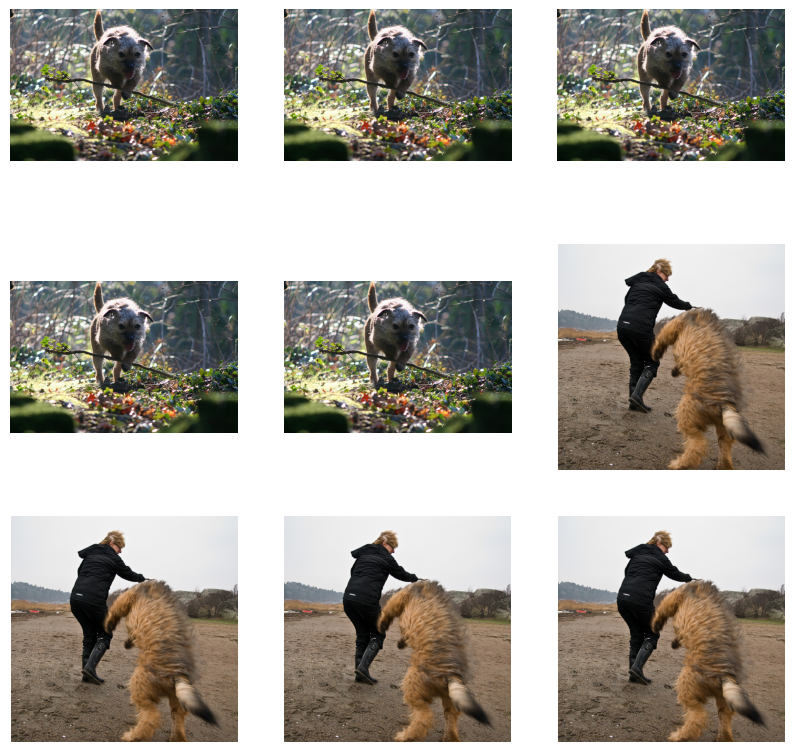

In [ ]:
def get_image_embeddings(dataframe, model_path):
    """
    Loads a model and generates image embeddings for the provided dataset.

    Parameters:
    - dataframe: DataFrame containing image file names.
    - model_path: Path to the saved model file.

    Returns:
    - model: Loaded CLIPModel instance.
    - image_embeddings: Tensor of image embeddings for the dataset.
    """
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    # Prepare data loader
    transforms = get_transforms(mode="valid")
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=False
    )

    # Generate image embeddings
    image_embeddings_list = []
    with torch.no_grad():
        for batch in tqdm(dataloader, colour="yellow", desc="Generating image embeddings"):
            images = batch["image"].to(CFG.device)
            image_features = model.image_encoder(images)
            image_embeddings = model.image_projection(image_features)
            image_embeddings_list.append(image_embeddings)

    # Concatenate all embeddings
    image_embeddings = torch.cat(image_embeddings_list, dim=0)
    return model, image_embeddings


# Interface Function to Use find_matches
if __name__ == "__main__":
    # Ensure the validation DataFrame and model are ready
    _, valid_df = make_train_valid_dfs()

    # Generate the model and image embeddings
    model, image_embeddings = get_image_embeddings(valid_df, "best_model.pth")

    # Define the Bangla text query and display matches
    query = "কক্সবাজারের সমুদ্র সৈকত"  # Bangla query for "cycle"
    find_matches(
        model=model,
        image_embeddings=image_embeddings,
        query=query,
        image_filenames=valid_df["image"].values,
        n=9,
    )
